In [1]:
import cv2, os, gc, csv, argparse
import tensorflow
import numpy as np
from os import path
from keras import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from scipy.spatial import distance
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import pandas as pd

In [2]:
def create_data(IM_DIR, ethnie, proportion): 
    # takes images from folder and associates them with a label - create a structure with names - labels - im
    prop = {0: [56, 56], 10: [50, 62], 20: [42, 70], 30: [32, 80], 40: [19, 93], 50: [0, 112]} # Dictionnaire avec le nombre d'images à enlever et total
    img = []
    label = []
    nom = []
    for imname in os.listdir(IM_DIR):
        img.append((cv2.imread(os.path.join(IM_DIR, imname), cv2.IMREAD_GRAYSCALE)))
        label.append(np.random.randint(low=0, high=2, size=56))
        nom.append(imname)
    dict = {'Image': img, 'Label': label, 'Nom': nom}
    data = pd.DataFrame(dict)

    a_enlever, nb_im = prop[proportion][0], prop[proportion][1]   
    masque = data['Nom'].str.contains(ethnie)
    # Filtrer les lignes où la valeur de la colonne 'nom' contient 'ch'
    df_filtre = data[masque]
    # Sélectionner aléatoirement 10 indices parmi les lignes filtrées
    indices_a_supprimer = np.random.choice(df_filtre.index, a_enlever, replace=False)
    # Supprimer les lignes correspondant aux indices sélectionnés aléatoirement
    df = data.drop(indices_a_supprimer)       
    dataframe = df.sample(frac=1).reset_index(drop=True)
    
    return dataframe, 56 - a_enlever, nb_im

def save_loss(history, epoques, nb_cc_value, ethnie, proportion):
    fig=plt.figure()
    plt.plot(range(epoques), history.get('loss'))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    fig.savefig(fname= '../2eme_Semestre/ID_Results/Loss/'+str(nb_cc_value)+"_"+ethnie+"_"+str(proportion)+"_"+'.png')

def save_mean(ytrain, prediction, run, nb_cc_value, ethnie, proportion, name_train):
    #sans lab_train mais avec ytrain:
    cpt_correct = 0
    with open('ID_Results/results.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        for i in range(len(prediction)):
            correct_vector_distance = distance.euclidean(prediction[i], ytrain[i])
            other_distances = [distance.euclidean(prediction[i], ytrain[j]) for j in range(len(ytrain)) if j != i]
            if correct_vector_distance <= min(other_distances):
                correct = 1
                cpt_correct += 1
            else:
                correct = 0
            writer.writerow([run, nb_cc_value, ethnie, proportion, name_train[i], correct])
    print("nb correct: ", cpt_correct, 'accuracy: ', np.round((cpt_correct / len(prediction)), 3))

def save_score(prediction, lab_train, name_train, run, nb_cc_value, ethnie, proportion):
    #save MEAN results dissociating CAU and ASIAN 
    cpt_correct_ch, cpt_correct_cau = 0, 0
    for i in range(len(prediction)):
        # distance pred à ground truth
        correct_vector_distance = distance.euclidean(prediction[i], lab_train[i])
        # distances entre la pred et tous les autres vecteurs
        other_distances = [distance.euclidean(prediction[i], lab_train[j]) for j in range(len(lab_train)) if j != i]
        #vérifie si la distance est bien la plus petite de toutes
        is_correct_prediction = correct_vector_distance <= min(other_distances)
        if "ch" in name_train[i]:
            cpt_correct_ch += is_correct_prediction
        elif "cau" in name_train[i]:
            cpt_correct_cau += is_correct_prediction

    # proportions d'essais corrects, ajout d'un epsilon pour pas diviser par zéro
    proportion_correct_ch = cpt_correct_ch / (len([name for name in name_train if "ch" in name]) + 2.220446049250313e-16)
    proportion_correct_cau = cpt_correct_cau / (len([name for name in name_train if "cau" in name]) + 2.220446049250313e-16)

    with open('ID_Results/summary.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([run, nb_cc_value, ethnie, proportion, proportion_correct_cau, proportion_correct_ch])
    

In [3]:
def create_model(nb_cc_value): 
    lrelu = tensorflow.keras.layers.LeakyReLU(alpha=0.2)
    model = tensorflow.keras.models.Sequential()
    model.add(tensorflow.keras.layers.Flatten())
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.Dense(900, activation = lrelu,
    kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=42)))
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.Dense(900, activation = lrelu,
    kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=42)))
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.Dense(nb_cc_value, activation = lrelu,
    kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=42)))
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.Dense(56, activation = 'sigmoid',
    kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=42)))

    lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.7, staircase=False)
    optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule, momentum = 0.9)
    model.compile(loss= 'mse', optimizer = optimizer, metrics = tensorflow.keras.metrics.MeanAbsoluteError())
    return model

                                               Image  \
0  [[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               Label               Nom  
0  [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, ...   Squar_fcau3.jpg  
1  [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...    Squar_fch2.jpg  
2  [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...  Squar_mcau12.jpg  
3  [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...   Squar_fch14.jpg  
4  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...    Squar_mch6.jpg  
nb_cc:  50 reduction : 50 ethnie :  ch
Epoch 1/100
4/4 [==============================] - 2s 27ms/step - loss: 0.2878 - mean_absolute_error: 0.4995
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.245

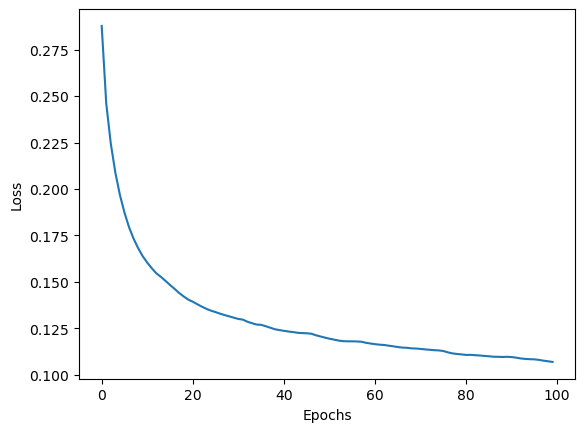

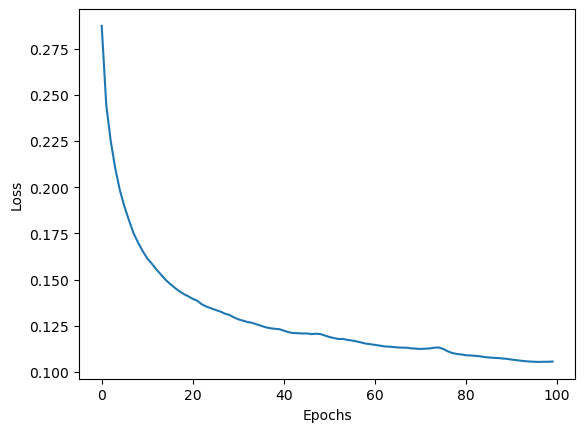

In [4]:
# %%--------------------------------------------------Initialization
nb_cc = [50]
ethnies = ["ch", "cau"]
prop = [0, 50] #0, 10, 20, 30, 40, 
epoques = 100

if not path.exists('ID_Results/results.csv'):
    with open('ID_Results/results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['run', 'nb_cc','ethnie','proportion', 'name_train', 'correct'])
if not path.exists('ID_Results/summary.csv'):
    with open('ID_Results/summary.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['run', 'nb_cc', 'ethnie', 'proportion', 'proportion_correct_cau', 'proportion_correct_ch'])

for nb_cc_value in nb_cc:
    for ethnie in ethnies:
        for proportion in prop:
            for run in range(1,1):


                data, nb_reduit, nb_im = create_data('../STIM_NB_LumNorm/', ethnie, proportion)
                print(data.head())

                print('nb_cc: ',nb_cc_value, 'reduction :', proportion, 'ethnie : ', ethnie)

                #%%----------------------------------------Processing data
                pairs_train = data['Image'].to_list() # image sous forme de matrice
                lab_train = data['Label'].to_list()   # vecteur associé à l'image
                name_train = data['Nom'].to_list()  # nom de l'image
                        
                xtrain = np.array(pairs_train).reshape((nb_im, 300, 300, 1))
                ytrain = np.array(lab_train)
                x_train = data['Image'].values
                y_train = data['Label'].values

                #%%----------------------------------------TRAIN
                model = create_model(nb_cc_value)
                history = model.fit(xtrain, ytrain, epochs=epoques,batch_size=32, shuffle=False)

                #plot and save training curve
                history_model = history.history
                save_loss(history_model, epoques, nb_cc_value, ethnie, proportion)
                
                #%%----------------------------------------TEST
                prediction = model(xtrain).numpy()
                save_mean(ytrain, prediction, run, nb_cc_value, ethnie, proportion, name_train)
                save_score(prediction, ytrain, name_train, run, nb_cc_value, ethnie, proportion)

                del data, xtrain, ytrain, prediction, model, history
                gc.collect()

In [13]:
del data, xtrain, ytrain, model, history, prediction
gc.collect()

NameError: name 'prediction' is not defined